In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import os
import time
import math
import shutil

import imageio
import librosa
import librosa.display
from IPython.display import Audio

torch.cuda.is_available()

True

## Display Graphs

#### display_graphs_bool

In [2]:
# Lists to store accuracy values for each epoch
metrics_train_accuracy = []
metrics_val_accuracy = []
metrics_train_loss = []
metrics_val_loss = []
metrics_epoch = []

def display_graphs(epoch, accuracy, val_accuracy, loss, val_loss):
    if isinstance(loss, torch.Tensor):
        loss = loss.cpu()

    loss = loss.detach().numpy()

    metrics_epoch.append(epoch+1)
    metrics_train_accuracy.append(accuracy)
    metrics_val_accuracy.append(val_accuracy)
    metrics_train_loss.append(loss)
    metrics_val_loss.append(val_loss)

    if (epoch+1) % interval == 0 or (epoch-1) == num_epochs:
        if epoch != 0:
            fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # Create a figure with two subplots
            axs[0].plot(metrics_epoch, metrics_train_accuracy, label='Training Accuracy', marker='o')
            axs[0].plot(metrics_epoch, metrics_val_accuracy, label='Validation Accuracy', marker='o')
            axs[0].set_xlabel('Epoch')
            axs[0].set_ylabel('Accuracy')
            axs[0].set_title('Training and Validation Accuracy')
            axs[0].set_ylim(acc_min_y, 1)
            axs[0].set_xlim(1, num_epochs)
            axs[0].legend()
            major_ticks = np.arange(0, num_epochs + 1, 5)
            minor_ticks = np.arange(0, num_epochs + 1, 1)
            axs[0].set_xticks(major_ticks)
            axs[0].set_xticks(minor_ticks, minor=True)
            axs[0].set_xticklabels(major_ticks.astype(int))
            axs[0].grid(True, which='both', linestyle='--', alpha=0.5)

            # Plot the loss graph in the second subplot
            axs[1].plot(metrics_epoch, metrics_train_loss, label='Training Loss', marker='o')
            axs[1].plot(metrics_epoch, metrics_val_loss, label='Validation Loss', marker='o')
            axs[1].set_xlabel('Epoch')
            axs[1].set_ylabel('Loss')
            axs[1].set_title('Training and Validation Loss')
            axs[1].set_ylim(0, loss_max_y)
            axs[1].set_xlim(1, num_epochs)
            axs[1].legend()
            major_ticks = np.arange(0, num_epochs + 1, 5)
            minor_ticks = np.arange(0, num_epochs + 1, 1)
            axs[1].set_xticks(major_ticks)
            axs[1].set_xticks(minor_ticks, minor=True)
            axs[1].set_xticklabels(major_ticks.astype(int))
            axs[1].grid(True, which='both', linestyle='--', alpha=0.5)

            plt.tight_layout()
            plt.show()

#### display_graphs_zoomed_bool

In [3]:
# Lists to store accuracy values for each epoch
metrics_train_accuracy = []
metrics_val_accuracy = []
metrics_train_loss = []
metrics_val_loss = []
metrics_epoch = []

def display_graphs_zoomed(epoch, accuracy, val_accuracy, loss, val_loss):
    if isinstance(loss, torch.Tensor):
        loss = loss.cpu()

    loss = loss.detach().numpy()

    metrics_epoch.append(epoch+1)
    metrics_train_accuracy.append(accuracy)
    metrics_val_accuracy.append(val_accuracy)
    metrics_train_loss.append(loss)
    metrics_val_loss.append(val_loss)

    # calc y limit for accuracy
    if accuracy < val_accuracy:
        acc_y_lim = accuracy
    else:
        acc_y_lim = val_accuracy
    acc_y_lim = acc_y_lim - (acc_y_lim * 0.5)
    # TypeError: can't multiply sequence by non-int of type 'float'

    acc_y_lim = math.floor(acc_y_lim * 10) / 10

    # calc y limit for loss
    if loss > val_loss:
        val_y_lim = loss
    else:
        val_y_lim = val_loss

    if (epoch+1) % interval == 0 or (epoch-1) == num_epochs:
        if epoch != 0:
            fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # Create a figure with two subplots
            # Plot the accuracy graph in the first subplot
            axs[0].plot(metrics_epoch, metrics_train_accuracy, label='Training Accuracy', marker='o')
            axs[0].plot(metrics_epoch, metrics_val_accuracy, label='Validation Accuracy', marker='o')
            axs[0].set_xlabel('Epoch')
            axs[0].set_ylabel('Accuracy')
            axs[0].set_title('Training and Validation Accuracy')
            axs[0].set_ylim(acc_y_lim, 1)
            axs[0].set_xlim(1, num_epochs)
            axs[0].grid(True, linestyle='--', alpha=0.5)
            axs[0].legend()
            major_ticks = np.arange(0, num_epochs + 1, 5)
            minor_ticks = np.arange(0, num_epochs + 1, 1)
            axs[1].set_xticks(major_ticks)
            axs[1].set_xticks(minor_ticks, minor=True)
            axs[1].set_xticklabels(major_ticks.astype(int))
            axs[1].grid(True, which='both', linestyle='--', alpha=0.5)

            # Plot the loss graph in the second subplot
            axs[1].plot(metrics_epoch, metrics_train_loss, label='Training Loss', marker='o')
            axs[1].plot(metrics_epoch, metrics_val_loss, label='Validation Loss', marker='o')
            axs[1].set_xlabel('Epoch')
            axs[1].set_ylabel('Loss')
            axs[1].set_title('Training and Validation Loss')
            axs[1].set_ylim(0, val_y_lim)
            axs[1].set_xlim(1, num_epochs)
            axs[1].set_xticks(range(1, num_epochs + 1, 5))
            axs[1].grid(True, linestyle='--', alpha=0.5)
            axs[1].legend()
            major_ticks = np.arange(0, num_epochs + 1, 5)
            minor_ticks = np.arange(0, num_epochs + 1, 1)
            axs[1].set_xticks(major_ticks)
            axs[1].set_xticks(minor_ticks, minor=True)
            axs[1].set_xticklabels(major_ticks.astype(int))
            axs[1].grid(True, which='both', linestyle='--', alpha=0.5)

            plt.tight_layout()
            plt.show()

## Data

#### Play an example audio file

In [4]:
file_path = r"Data\Audio\0\0_george_0.wav"
Audio(file_path)

## Model

In [4]:
class AudioRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AudioRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = 128  # depends on the feature extraction method
hidden_size = 256
num_layers = 2
num_classes = 10  # 10 digits

model = AudioRNN(input_size, hidden_size, num_layers, num_classes)

#### Define parameters

In [5]:
batch_size = 16
num_epochs = 50
learning_rate = 0.001
use_scheduler = True

display_graphs_bool = True
acc_min_y = 0.5
loss_max_y = 2
display_graphs_zoomed_bool = False
interval = 10
debug = False

In [6]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
if use_scheduler:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

#### Preprocess Data

In [36]:
import os
from typing import Tuple
import torchaudio
from torch.utils.data import Dataset
from torch import Tensor
from pathlib import Path



data_dir = r"Data\Audio"

def load_audio_item(filepath: str, path: str, label_name: str) -> [Tensor, int, str, str]:
    relpath = os.path.relpath(filepath, path)
    label, filename = os.path.split(relpath)
    if label_name is not None:
        label = label_name
    waveform, sample_rate = torchaudio.load(filepath)
    return waveform, sample_rate, label, filename

class AudioFolder(Dataset):
    """Create a Dataset from Local Files.

    Args:
        path (str): Path to the directory where the dataset is found or downloaded.
        suffix (str) : Audio file type, defaulted to ".WAV".
        pattern (str) : Find pathnames matching this pattern. Defaulted to "*/*" 
        new_sample_rate (int) : Resample audio to new sample rate specified.
        spectrogram_transform (bool): If `True` transform the audio waveform and returns it  
        transformed into a spectrogram tensor.
        label (str): The label is pulled from the folders in the path, this allows you to statically
        define the label string.
    """


    def __init__(
            self,
            path: str,
            suffix: str = ".wav",
            pattern: str = "*/*",
            new_sample_rate: int = None,
            spectrogram_transform: bool = False,
            label: str = None
        ):
        
        self._path = path
        self._spectrogram_transform = spectrogram_transform
        self._new_sample_rate = new_sample_rate
        self._label = label

        walker = sorted(str(p) for p in Path(self._path).glob(f'{pattern}{suffix}'))
        self._walker = list(walker)

    def __getitem__(self, n: int) -> Tuple[Tensor, int, str, str]:
        """Load the n-th sample from the dataset.

        Args:
            n (int): The index of the file to be loaded

        Returns:
            tuple: ``(waveform, sample_rate, label, filename)``
        """
        fileid = self._walker[n]

        waveform, sample_rate, label, filename =  load_audio_item(fileid, self._path, self._label)

        if self._new_sample_rate is not None:
            waveform = torchaudio.transforms.Resample(sample_rate, self._new_sample_rate)(waveform)
            sample_rate = self._new_sample_rate
        if self._spectrogram_transform is not None:
           waveform = torchaudio.transforms.Spectrogram()(waveform)

        return waveform, sample_rate, label, filename



    def __len__(self) -> int:
        return len(self._walker)
    
full_dataset = AudioFolder(data_dir)

In [37]:
# Split the data into training and test sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
test_size = len(full_dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # A mini-batch is a list of tuples (waveform, label)
    waveforms, labels = zip(*batch)

    # Pad the waveforms and stack them
    waveforms = pad_sequence(waveforms, batch_first=True)

    # Stack the labels as well
    labels = torch.stack(labels)

    return waveforms, labels

# Dataloaders
batch_size = 16
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, collate_fn=collate_fn)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn)

print(len(test_dataset))
print(len(train_dataset))


print(f"Moving model to device...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if GPU is available
print(f"Device count: {device}")
model.to(device)  # Move the model to the device (CPU or GPU)
print("Complete")

print("Setting up model...")
model.train()  # Set the model to training mode

loss_function = nn.CrossEntropyLoss()  # Define the loss function
model.zero_grad()  # Reset gradients tensors
optimizer.zero_grad()  # Reset optimizer gradients
print("Complete")

total_steps = len(train_loader)  # Total number of steps in an epoch

600
2400
Moving model to device...
Device count: cuda
Complete
Setting up model...
Complete


#### Save callback

In [38]:
checkpoint_dir = "ModelSaves\LSTM"
model_name = "M1"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(epoch, model, optimizer, loss, val_loss, accuracy, val_accuracy):
    checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_epoch_{epoch+1}_loss_{loss:.4f}_vloss{val_loss:.4f}_acc_{accuracy:.4f}_vacc{val_accuracy:.4f}.pt')
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, checkpoint_path)

def save_model(epoch, model, optimizer, loss, val_loss, accuracy, val_accuracy):
    path = os.path.join(checkpoint_dir, f'{model_name}_epoch_{epoch+1}_loss_{loss:.4f}_vloss{val_loss:.4f}_acc_{accuracy:.4f}_vacc{val_accuracy:.4f}.pt')
    torch.save(model, path)

#### Training

In [39]:
print("Beginning training...")
for epoch in range(num_epochs):
  progress_bar = tqdm(train_loader, total=total_steps, leave=True)
  total_correct = 0
  total_samples = 0
  for i, (inputs, labels) in enumerate(progress_bar):
    inputs = inputs.to(device)
    labels = labels.to(device)
    predictions = model(inputs)
    if debug == True:
      print('*** DEBUG ***')
      print('Predictions: ', predictions.shape)
      print('Labels: ', labels.shape)
      print('Inputs: ', inputs.shape)
      print()

    loss = loss_function(predictions, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, predicted_labels = torch.max(predictions, 1)
    total_correct += (predicted_labels == labels).sum().item()
    total_samples += labels.size(0)

    progress_bar.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
    progress_bar.set_postfix(loss=loss.item())

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_correct = 0
    val_samples = 0
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      predictions = model(inputs)
      loss = loss_function(predictions, labels)

      _, predicted_labels = torch.max(predictions, 1)
      val_correct += (predicted_labels == labels).sum().item()
      val_samples += labels.size(0)
      val_loss += loss.item()

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_samples
    accuracy = total_correct / total_samples

    if use_scheduler:
      scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Acc: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

  if display_graphs_bool == True:
    display_graphs(epoch, accuracy, val_accuracy, loss, val_loss)
  if display_graphs_zoomed_bool == True:
    display_graphs_zoomed(epoch, accuracy, val_accuracy, loss, val_loss)

  save_checkpoint(epoch, model, optimizer, loss, val_loss, accuracy, val_accuracy)
  save_model(epoch, model, optimizer, loss, val_loss, accuracy, val_accuracy)

  model.train()

Beginning training...


  0%|          | 0/150 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

## Test Model

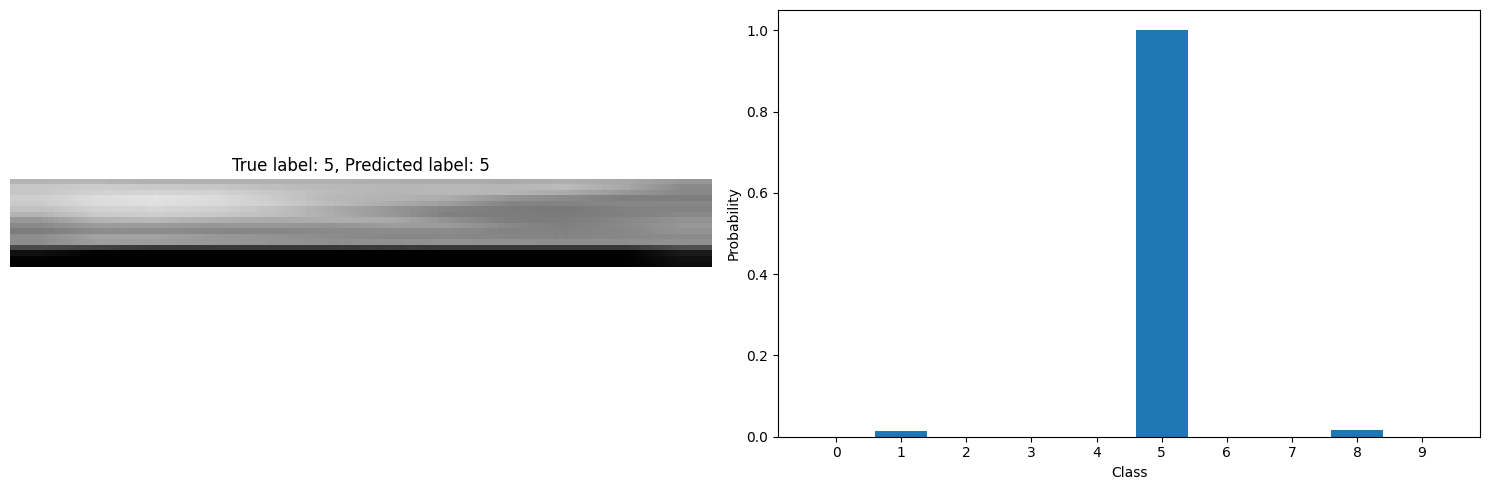

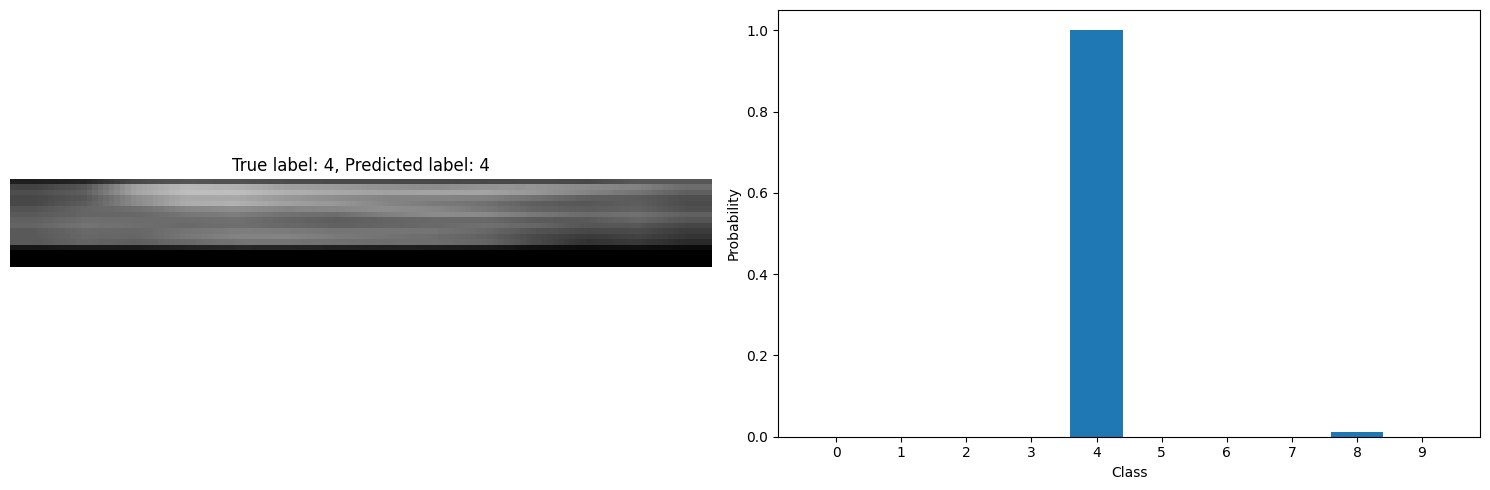

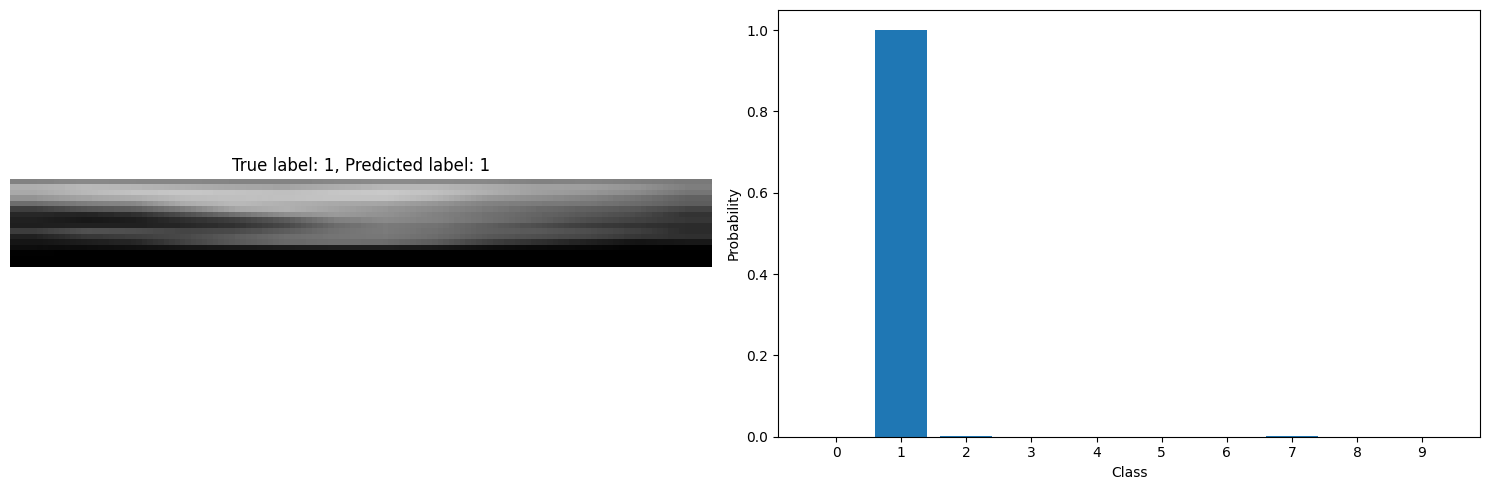

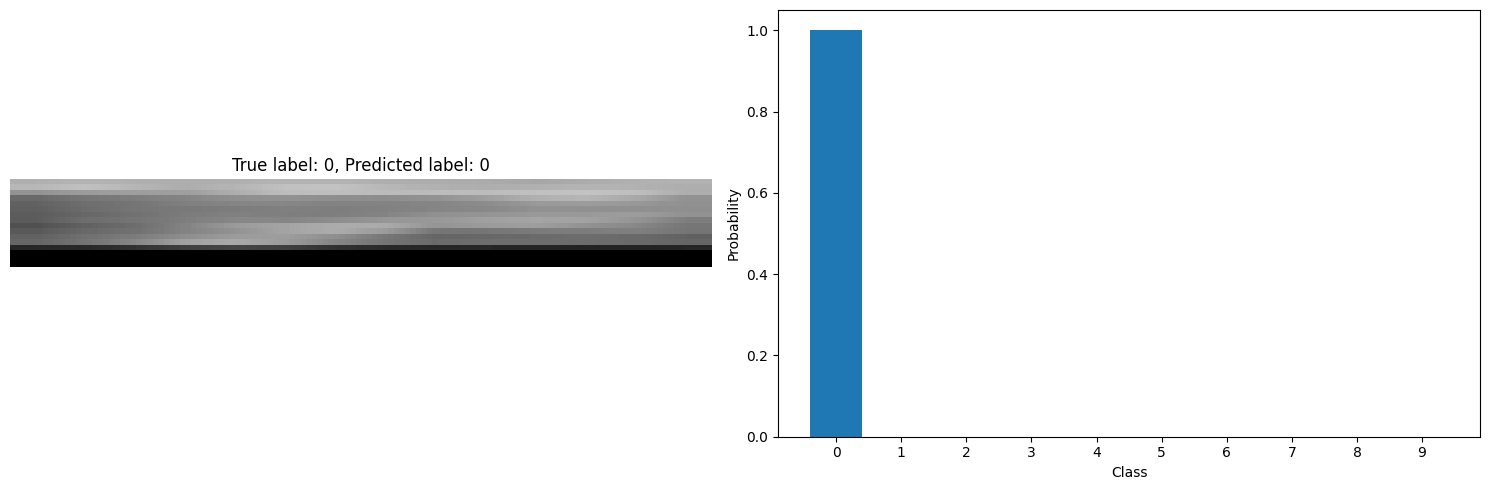

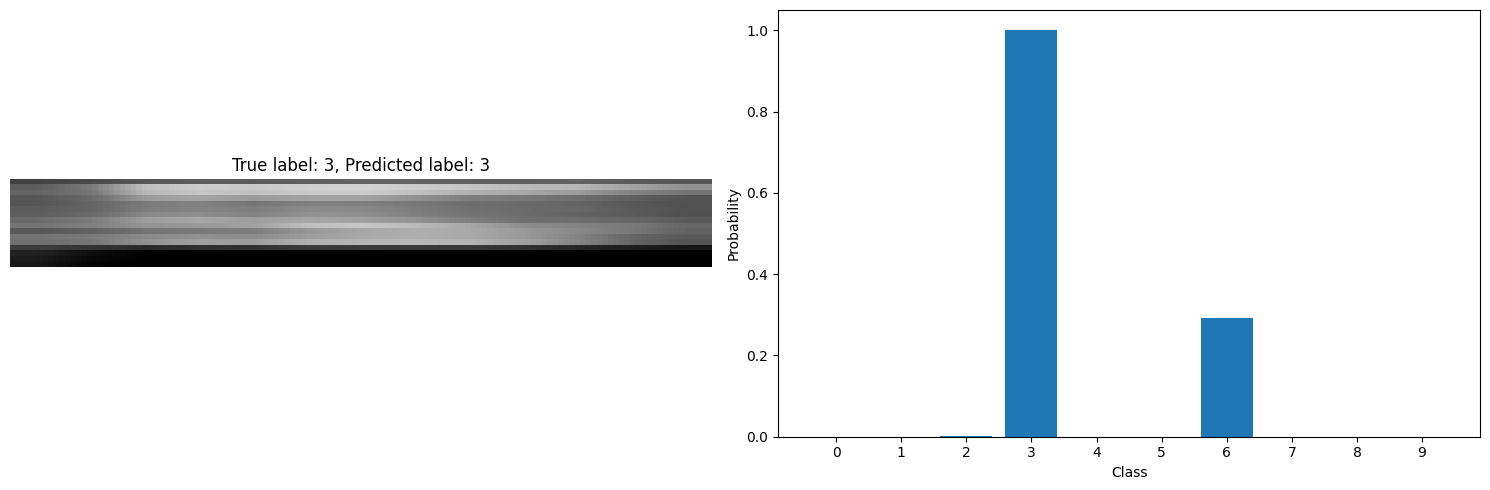

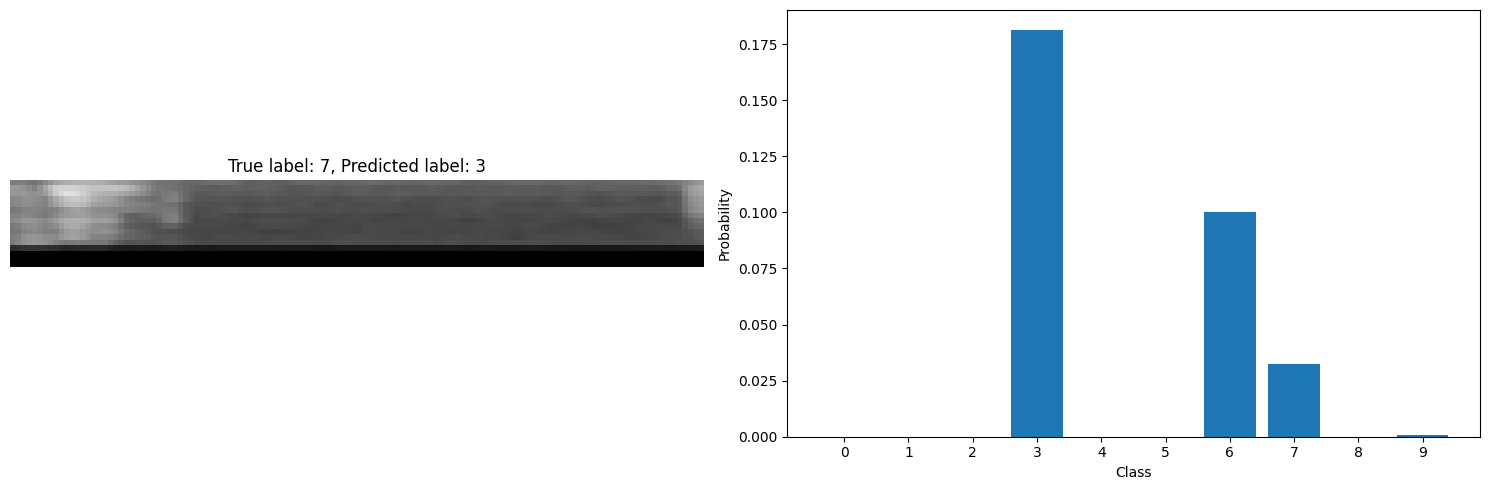

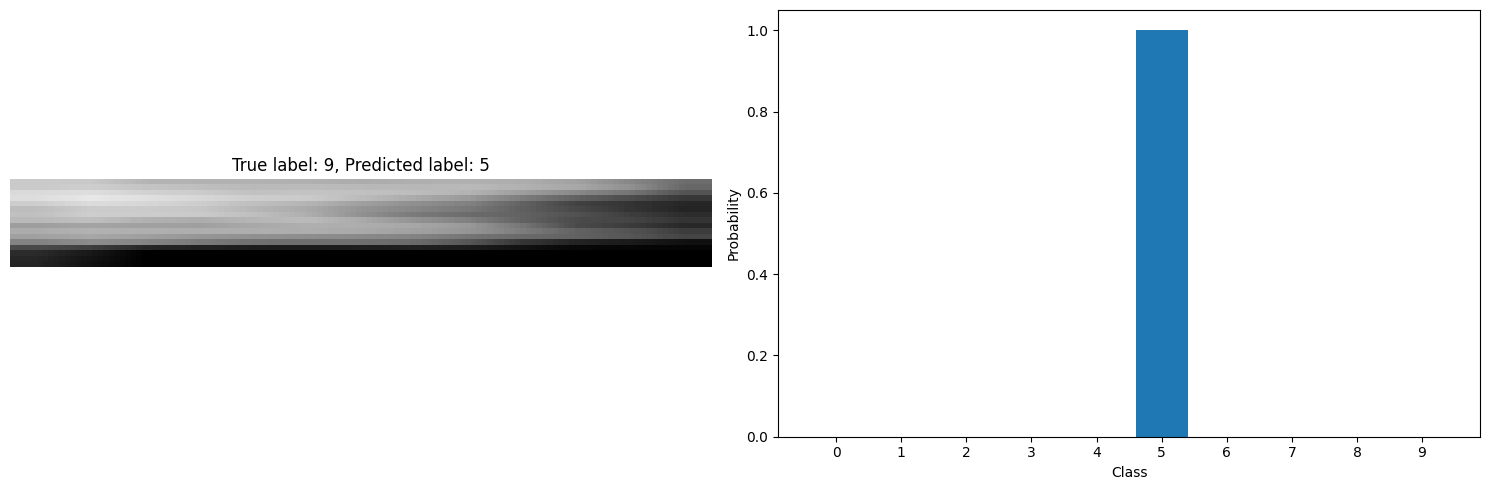

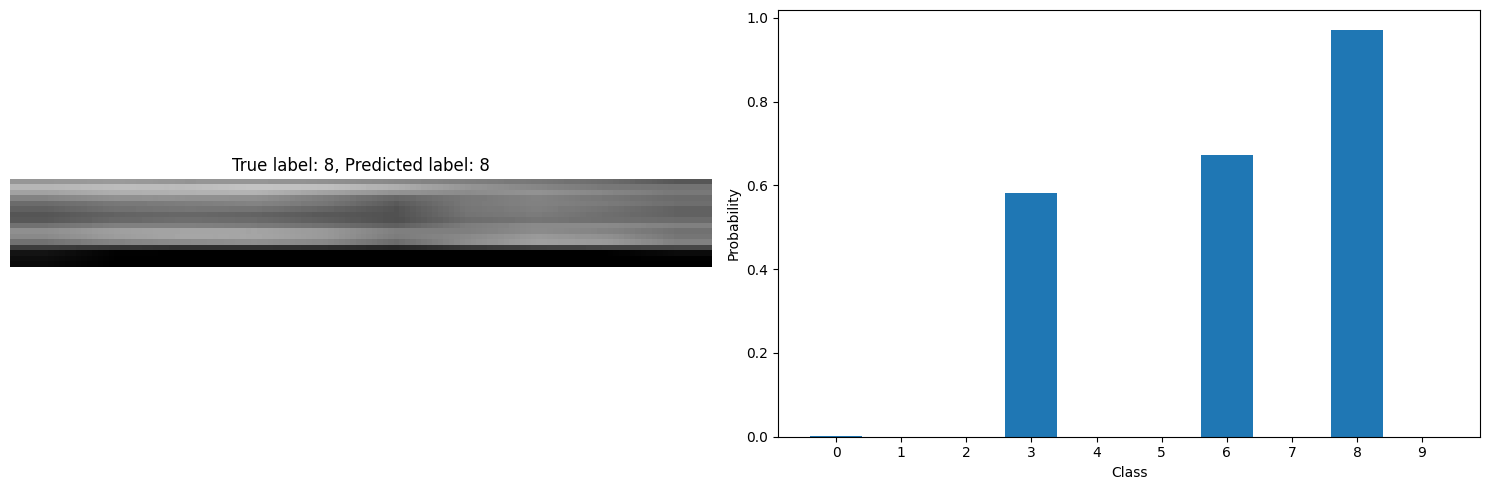

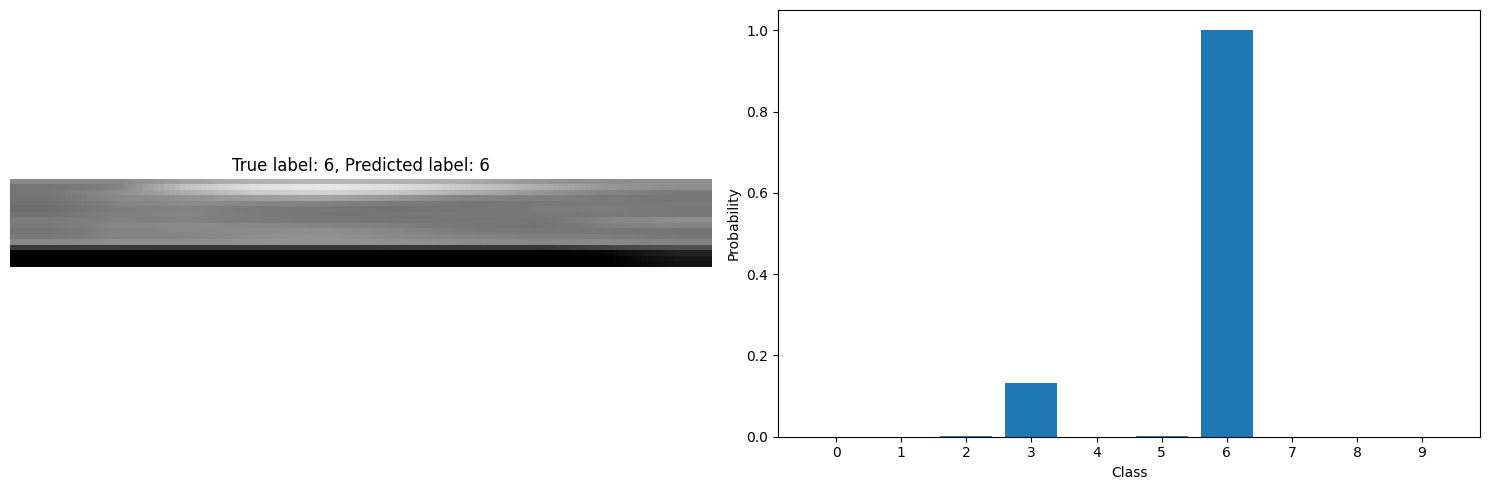

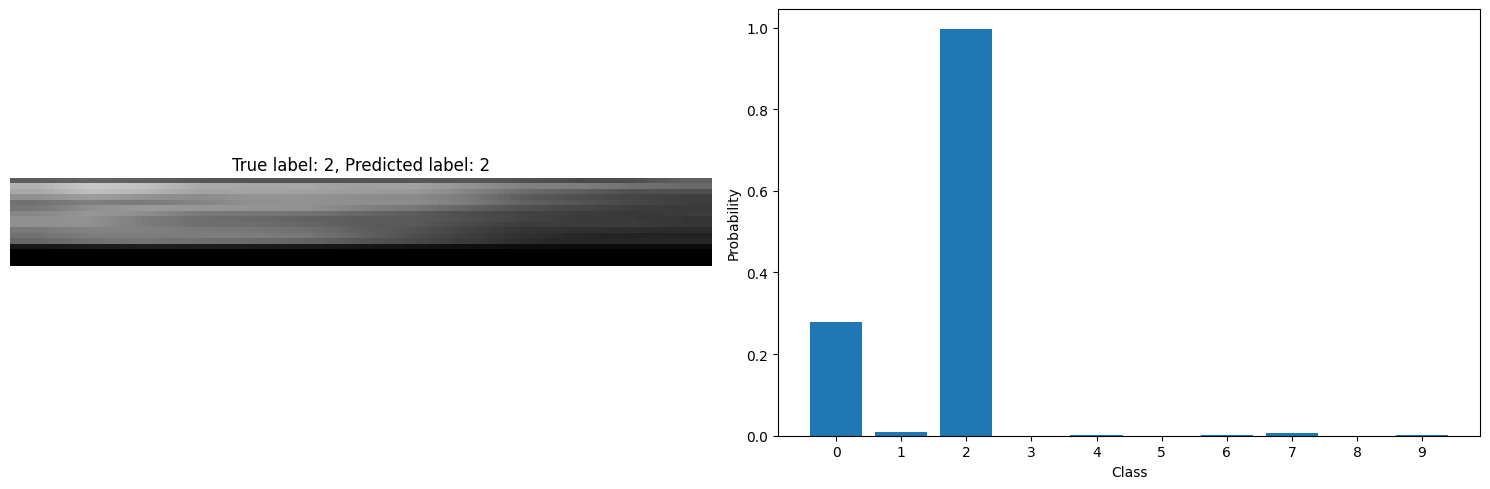

In [15]:
def show_predictions(model, test_dataset, num_images_per_class):
    model.eval()

    # Initialize a dictionary to store the indices of the first occurrence of each class
    class_indices = {}

    # Iterate over the test dataset to find the first occurrence of each class
    for index, (_, label) in enumerate(test_dataset):
        if label not in class_indices:
            class_indices[label] = index

    # Iterate over the class indices and display the specified number of images for each class
    for label, index in class_indices.items():
        for i in range(num_images_per_class):
            if i == 0:
                input_image, _ = test_dataset[index]
            else:
                input_image, _ = test_dataset[index + i]

            with torch.no_grad():
                input_image = input_image.to(device)

                output = model(input_image.unsqueeze(0))
                _, predicted = torch.max(output, 1)
                predicted_label = predicted.item()

            image = input_image.squeeze().cpu().numpy()

            fig, axs = plt.subplots(1, 2, figsize=(15, 5))
            if len(image.shape) == 3:
                sample_image = np.transpose(image, (1, 2, 0))
            elif len(image.shape) == 2:
                sample_image = image

            axs[0].imshow(sample_image,
                          cmap='gray',
                          vmin=0, vmax=1)
            axs[0].set_title("True label: {}, Predicted label: {}".format(label, predicted_label))
            axs[0].axis('off')

            probability = output.cpu()[0].detach().numpy()

            classes = ['0', '1', '2', '3', '4',
                     '5', '6', '7', '8', '9']

            axs[1].bar(classes, probability)
            axs[1].set_xlabel('Class')
            axs[1].set_ylabel('Probability')

            # Rotate the x-axis labels vertically
            #axs[1].tick_params(axis='x', rotation=90)

            plt.tight_layout()
            plt.show()

# Call the function to show predictions
num_images_per_class = 1  # Specify the number of images per class
show_predictions(model, test_dataset, num_images_per_class)